In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from getdist import plots, MCSamples, loadMCSamples
import classy as Class
import getdist
import pickle as pkl

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

dirname = "/Users/gabe/projects/recombination/data/chains/modrec/chains"
sample_path = os.path.join(dirname, "modrec")
s = loadMCSamples(sample_path, settings={'ignore_rows': 0.5})

shoes_path = os.path.join(dirname, "modrec.post.SHOES")
shoes = loadMCSamples(shoes_path)

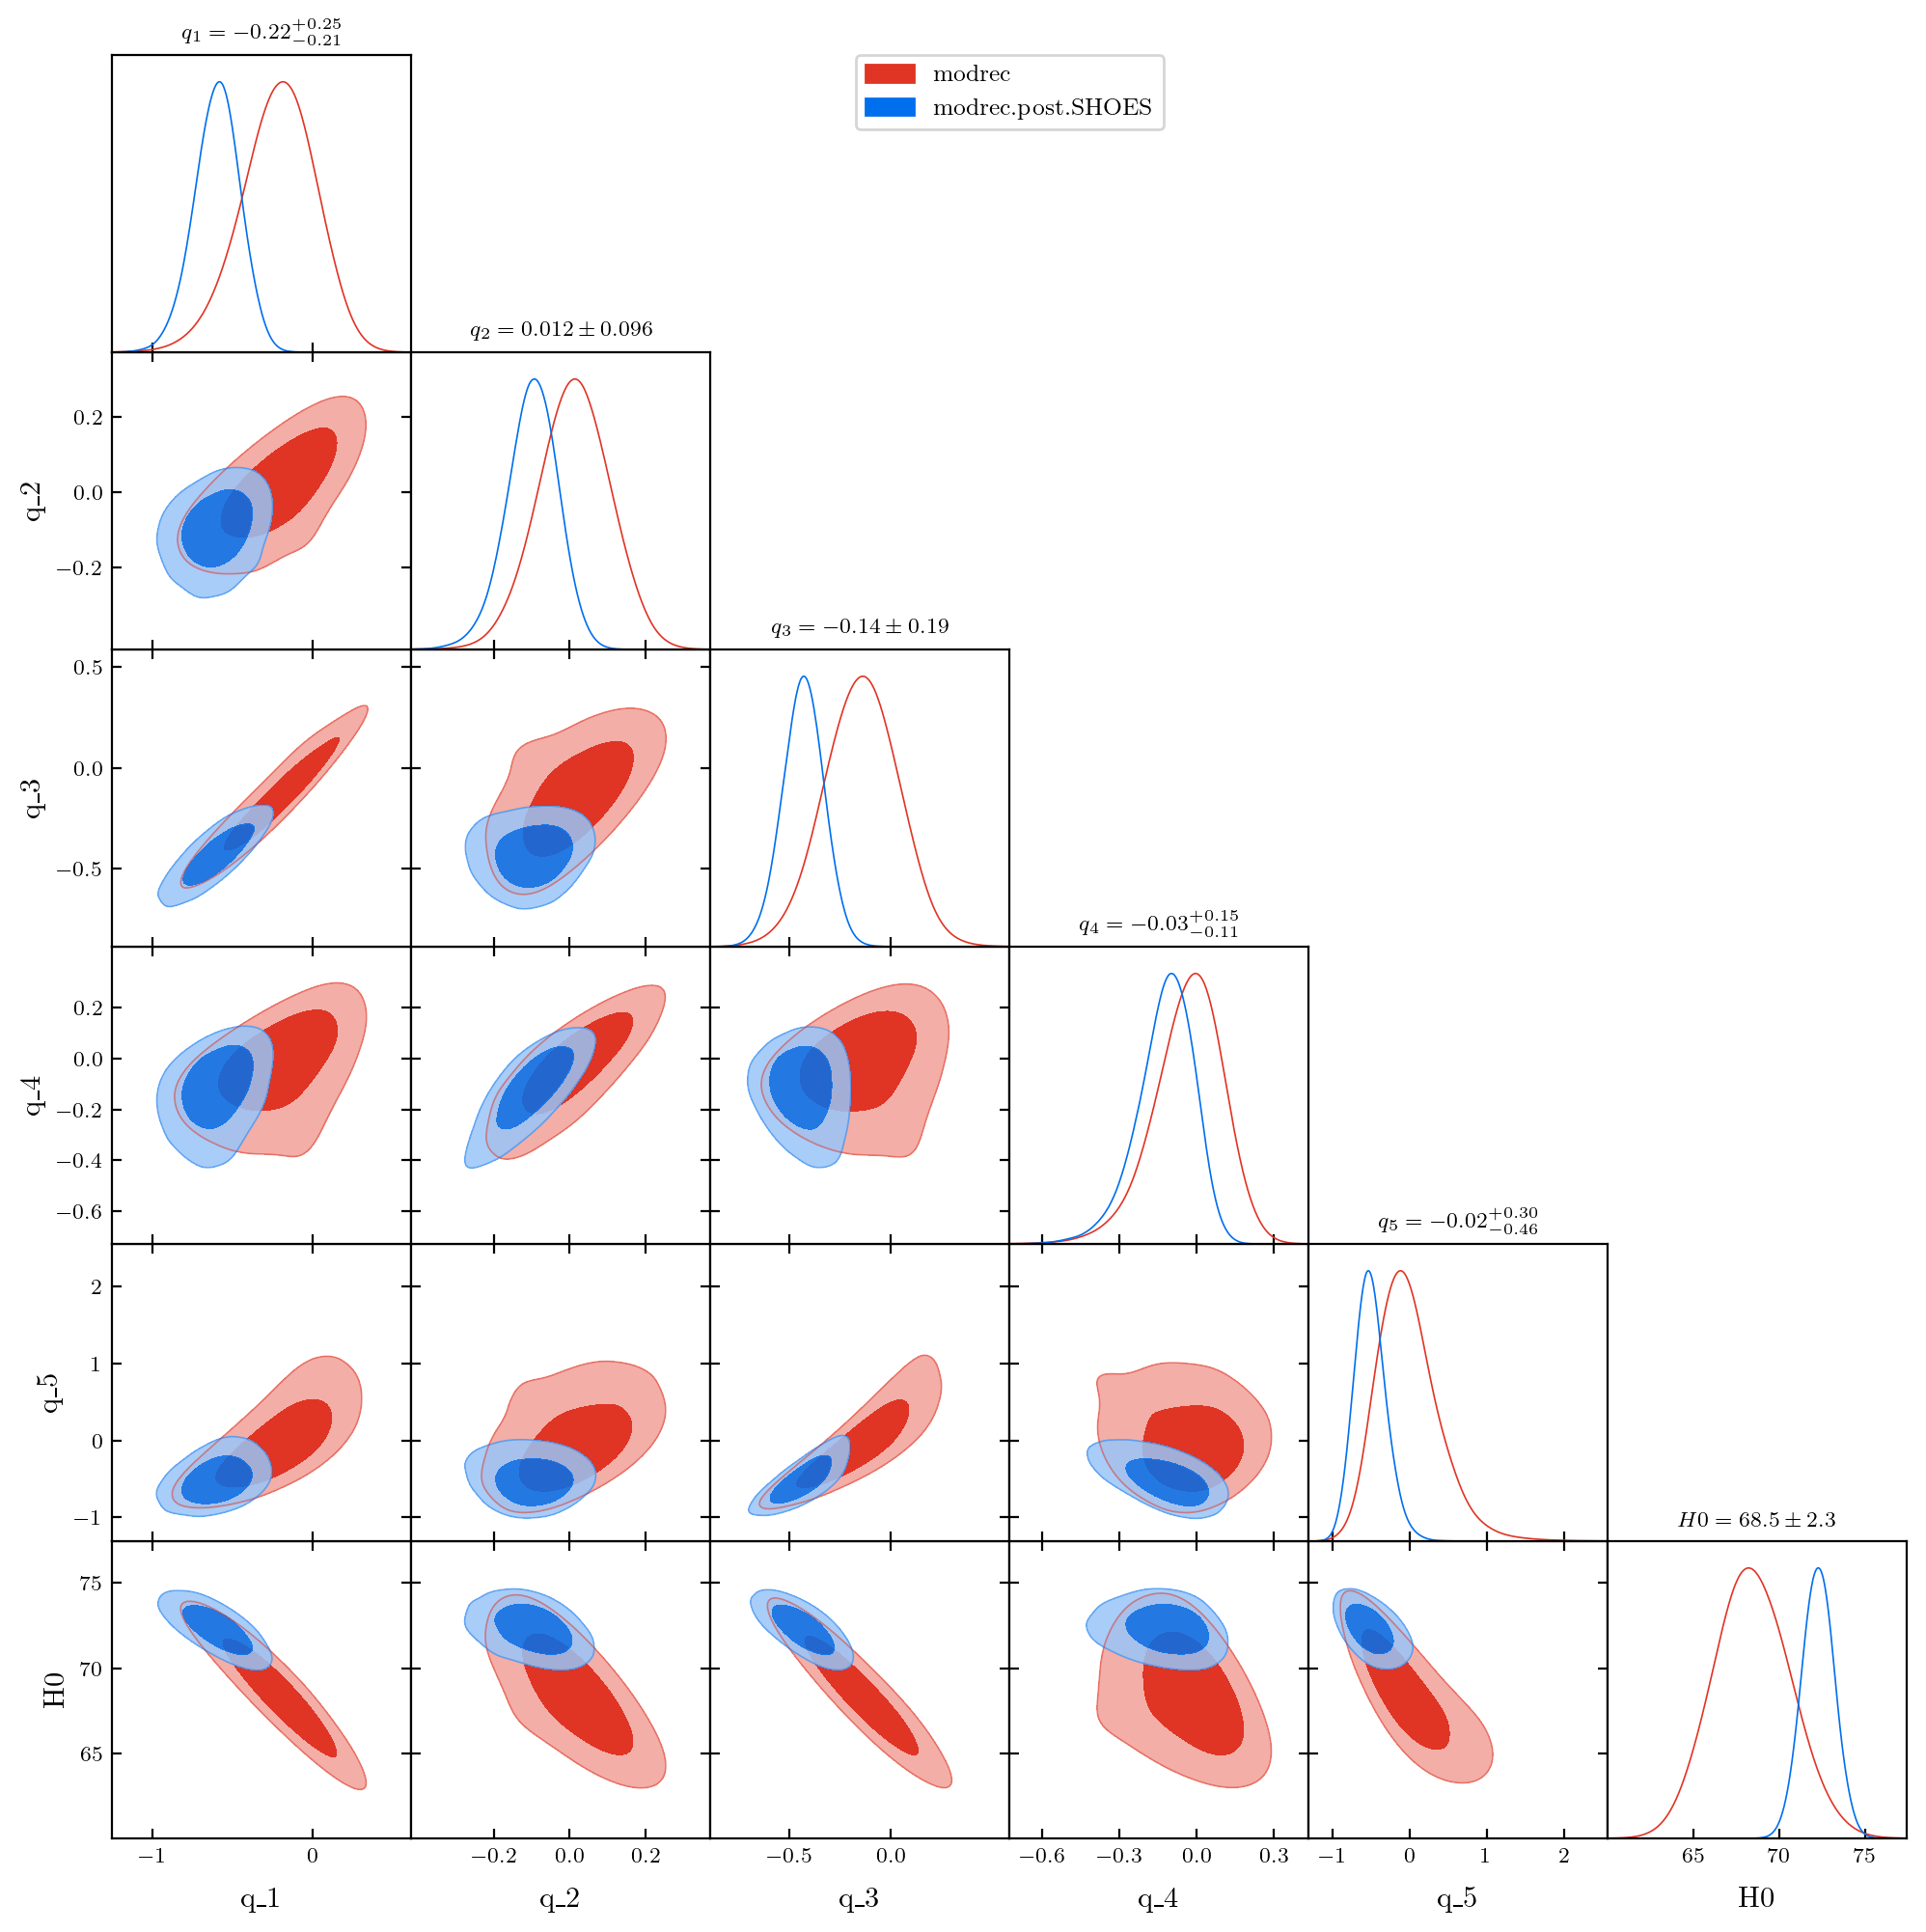

In [5]:
g = plots.get_subplot_plotter()
g.triangle_plot([s, shoes], ["q_1", "q_2", "q_3", "q_4", "q_5", "H0"], filled=True, title_limit=1)
#g.triangle_plot([s, shoes], ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'logA', 'H0'], filled=True, title_limit=1)
#g.export(fname="../results/triangle_modrec_standard.pdf")

In [3]:
base_samples = np.split(s.samples,s.chain_offsets[1:-1])
base_chains = []

rename_dict = {}

with open("/Users/gabe/projects/emulators/data/modrec/chains/modrec.paramnames", "r") as f:
    lines = [l.strip() for l in f.readlines()]
    for i,name in enumerate(lines):
        rename_dict["param{}".format(i+1)] = name

for samp in base_samples:
    chain = MCSamples()
    print(len(samp))
    chain.loadChains(root="/Users/gabe/projects/emulators/data/modrec/chains/modrec", files_or_samples=samp)
    chain.setParamNames("/Users/gabe/projects/emulators/data/modrec/chains/modrec.paramnames")
    base_chains.append(chain)

505440
519129
508899
503010
522275
515957
518894
506000


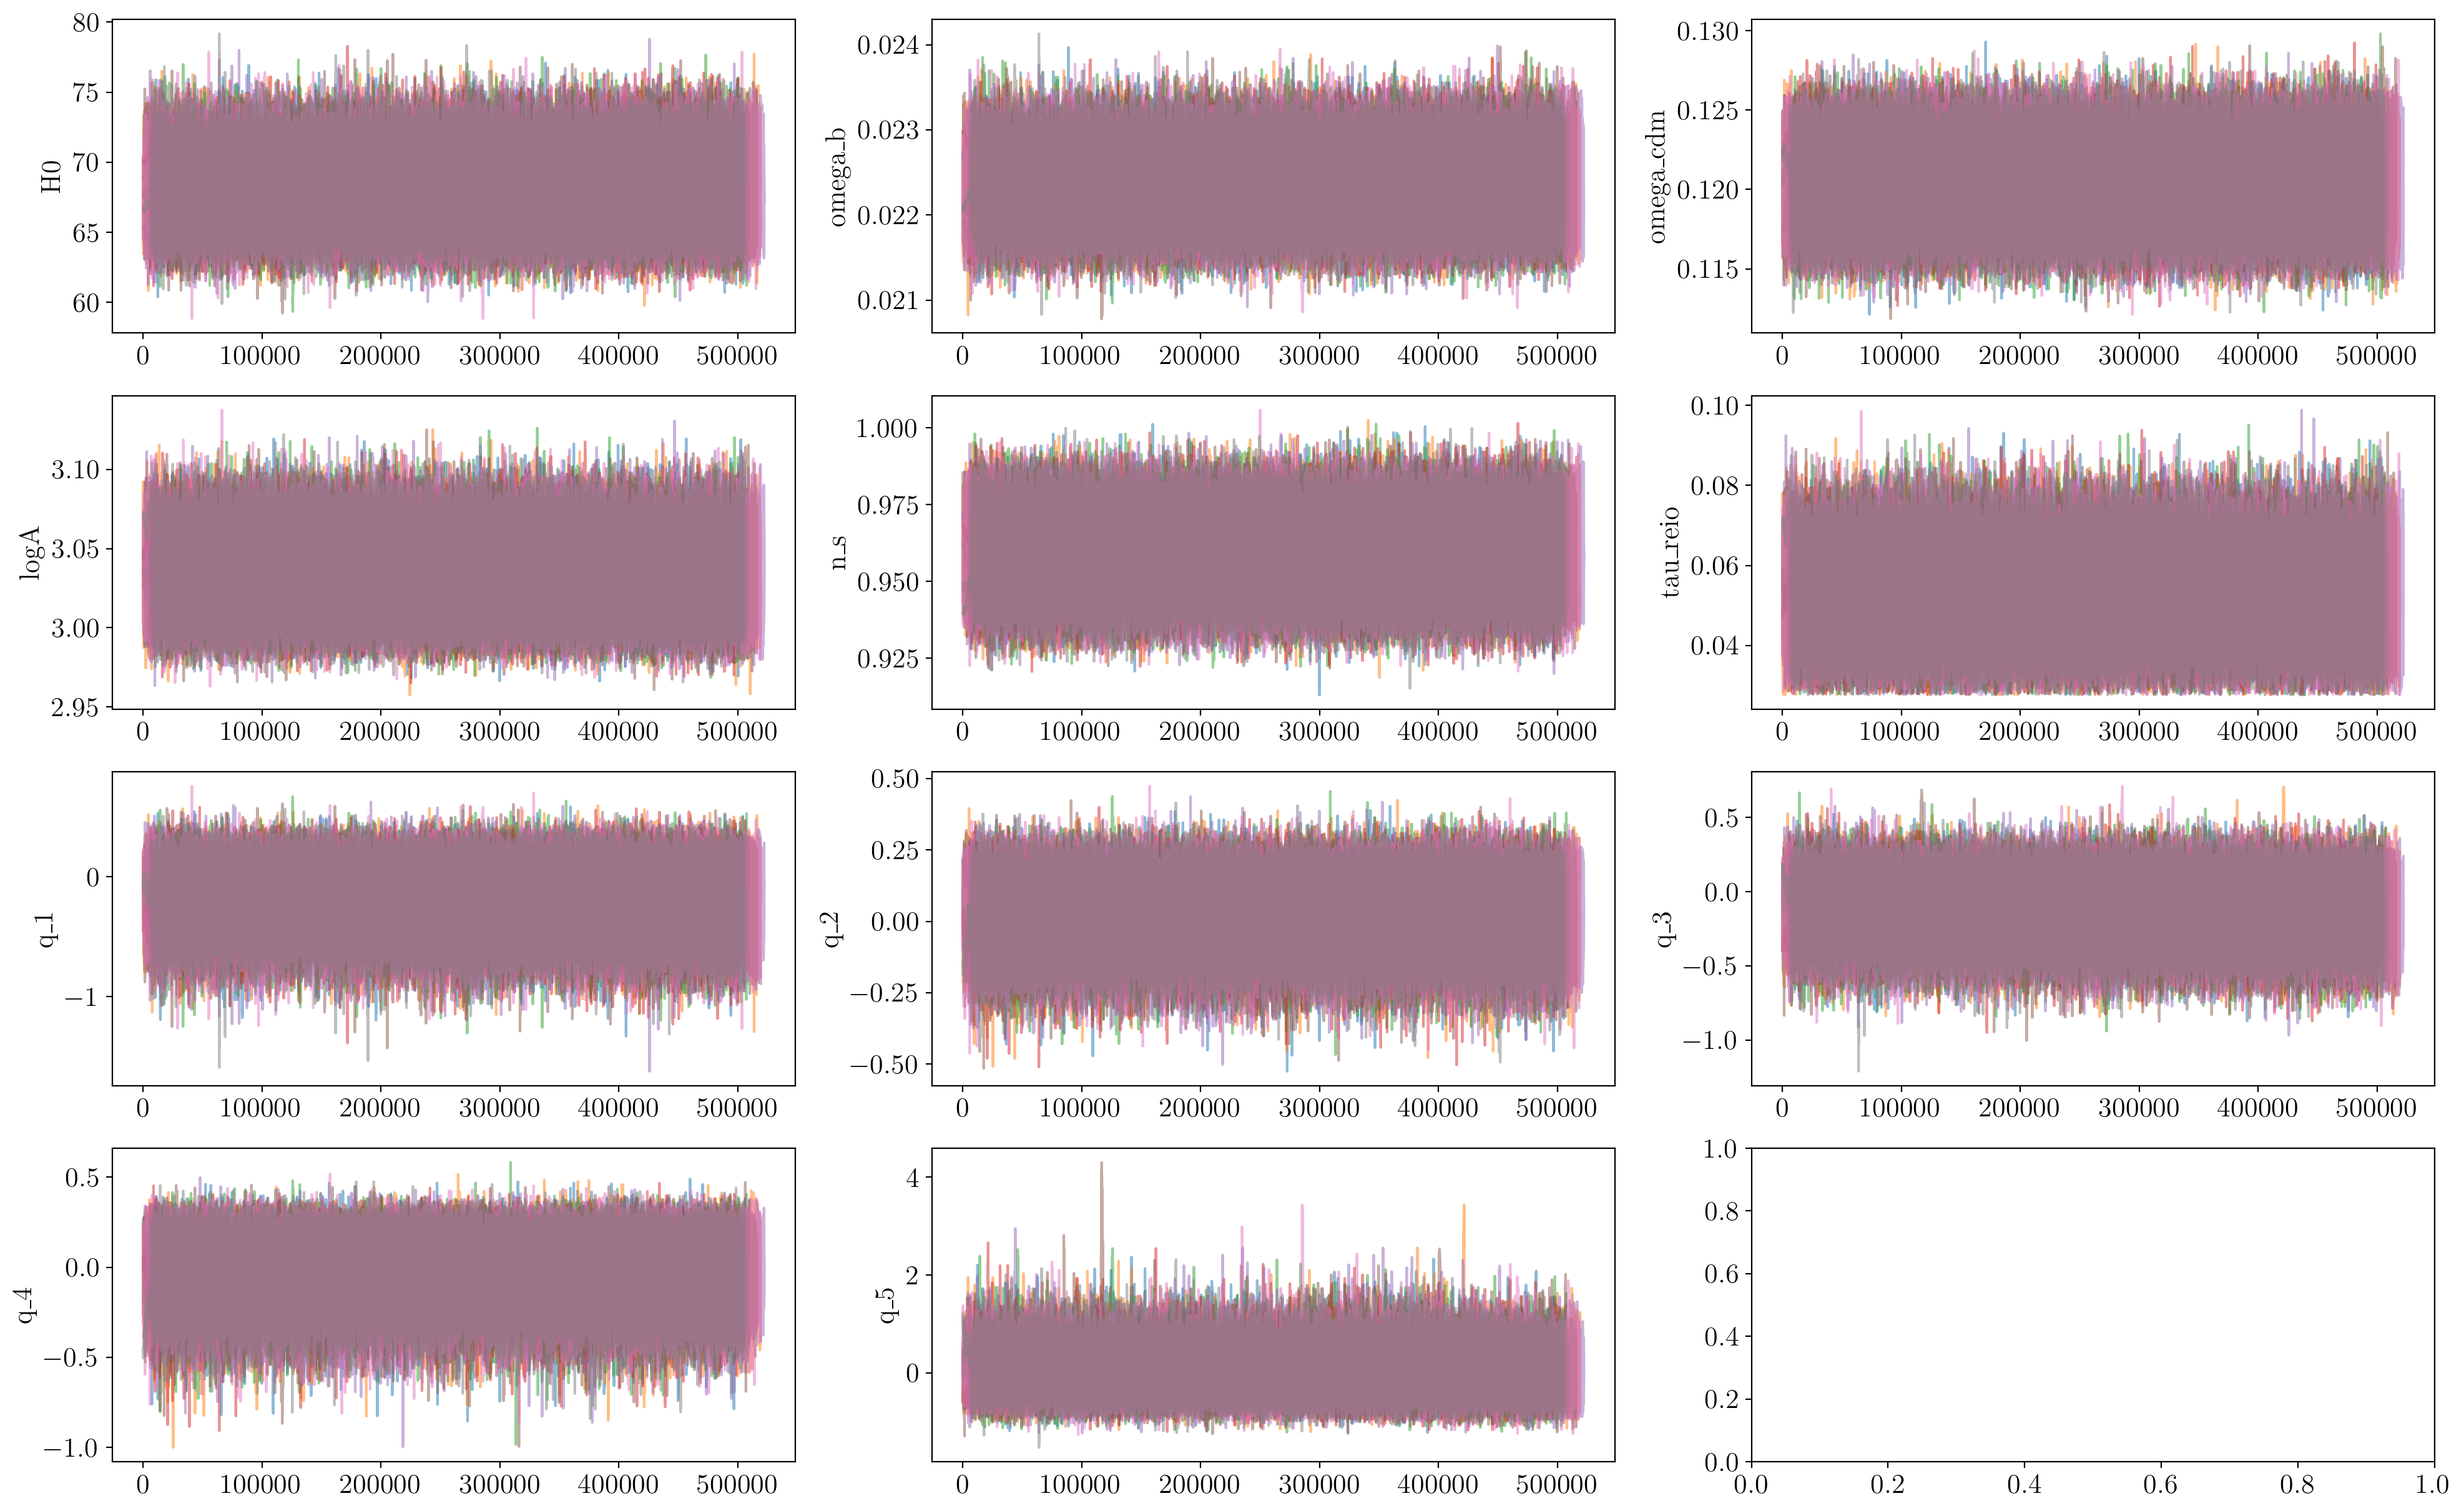

In [4]:
params_to_plot = ["H0", "omega_b", "omega_cdm", "logA", "n_s", "tau_reio", "q_1", "q_2", "q_3", "q_4", "q_5"]

fig,ax=plt.subplots(nrows=4, ncols=3, figsize = (24, 15))

for i,p in enumerate(params_to_plot):
    ax.flatten()[i].set_ylabel(p)
    for chain in base_chains:
        samples = chain.getParams().__dict__[p]
        ax.flatten()[i].plot(samples, alpha=0.5)
plt.savefig("../results/traceplot_modrec.png", dpi=300, bbox_inches="tight")

In [6]:
def find_index_of(array, values):
    indices_return = []
    for value in values:
        test = np.where(array<value, 1, 0)
        ind = np.argwhere(np.diff(test)!=0)[0][0]
        indices_return.append(ind)
    return indices_return

######################################################
# Loading best fit values for LCDM run and computing
######################################################

dirname = "/Users/gabe/projects/cobaya/data/lcdm_baseline_fixed_connect/chains"
sample_path = os.path.join(dirname, "lcdm_baseline_fixed_connect")
ll_max = 4000 #maximum \ell we will consider
lcdm_sample = loadMCSamples(sample_path, settings={'ignore_rows': 0.25})
lcdm_bestfit = lcdm_sample.getParamBestFitDict()
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none',
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

param_dict = {'H0': lcdm_bestfit["H0"],
              'omega_b': lcdm_bestfit["omega_b"],
              'omega_cdm': lcdm_bestfit["omega_cdm"],
              'ln10^{10}A_s': lcdm_bestfit["logA"],
              'n_s': lcdm_bestfit["n_s"],
              'tau_reio': lcdm_bestfit["tau_reio"]
              }

common_settings.update(param_dict)

M = Class.Class()
M.set(common_settings)
M.compute()

######################################################
# Computing fiducial thermodynamics
######################################################

thermo = M.get_thermodynamics()

cutoff_redshifts = [200, 2500]

cutoffs = find_index_of(thermo["z"], cutoff_redshifts)
z = thermo['z'][cutoffs[0]:cutoffs[1]]
xe_fid = thermo['x_e'][cutoffs[0]:cutoffs[1]]
viz = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]
gz_fid = viz[cutoffs[0]:cutoffs[1]]

Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Computing fiducial spectra
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

In [46]:
import pickle

modrec = s.getParams().__dict__
H0_high_bounds = [72, 73]
high_H0_ind = np.argwhere(np.logical_and((modrec["chi2__CMB"]-lcdm_bestfit["chi2__CMB"])<0, np.logical_and(modrec["H0"]>H0_high_bounds[0], modrec["H0"]<H0_high_bounds[1]))).flatten()
print(len(high_H0_ind))

list_of_models = []

for i in high_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string,
                "global_index": i
                }
    list_of_models.append(param_dict)

with open('../data/model_list.pkl', 'wb') as f:
    pickle.dump(list_of_models[:5], f)

64


In [24]:
common_settings = {'output' : 'tCl,pCl,lCl',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'control',
                   'xe_pert_num': 7,
                   'zmin_pert': 800,
                   'zmax_pert': 1400,
                   'xe_control_pivots': "800.0000,900.0000,1000.0000,1100.0000,1200.0000,1300.0000,1400.0000",
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                   'l_max_scalars': ll_max,
                   'start_sources_at_tau_c_over_tau_h': 0.004
                  }

M = Class.Class()
M.set(common_settings)

tt_high_dict = {}
te_high_dict = {}
ee_high_dict = {}
xe_dict = {}
xe_pert_dict = {}
xe_fid_dict = {}
gz_dict = {}

for i in high_H0_ind:
    cp_string = "0.0,{},{},{},{},{},0.0".format(modrec["q_1"][i], modrec["q_2"][i], modrec["q_3"][i], modrec["q_4"][i], modrec["q_5"][i])
    param_dict = {'H0': modrec["H0"][i],
                'omega_b': modrec["omega_b"][i],
                'omega_cdm': modrec["omega_cdm"][i],
                'ln10^{10}A_s': modrec["logA"][i],
                'n_s': modrec["n_s"][i],
                'tau_reio': modrec["tau_reio"][i],
                "xe_control_points": cp_string
                }
    M.set(param_dict)
    M.compute()
    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2
    tt = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
    te = muK2*M.lensed_cl(ll_max)['te'][2:]
    ee = muK2*M.lensed_cl(ll_max)['ee'][2:]
    tt_high_dict[i] = tt
    te_high_dict[i] = te
    ee_high_dict[i] = ee
    thermo = M.get_thermodynamics()
    cutoff_redshifts = [200, 2500]
    cutoffs = find_index_of(thermo["z"], cutoff_redshifts)
    z = thermo['z'][cutoffs[0]:cutoffs[1]]
    xe_dict[i] = thermo['x_e'][cutoffs[0]:cutoffs[1]]
    xe_pert_dict[i] = thermo["xe_pert"][cutoffs[0]:cutoffs[1]]
    xe_fid_dict [i] = thermo['x_fid'][cutoffs[0]:cutoffs[1]]
    viz = thermo["kappa' [Mpc^-1]"]*thermo["exp(-kappa)"]
    gz_dict[i] = viz[cutoffs[0]:cutoffs[1]]

/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_51488/3169696350.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap)


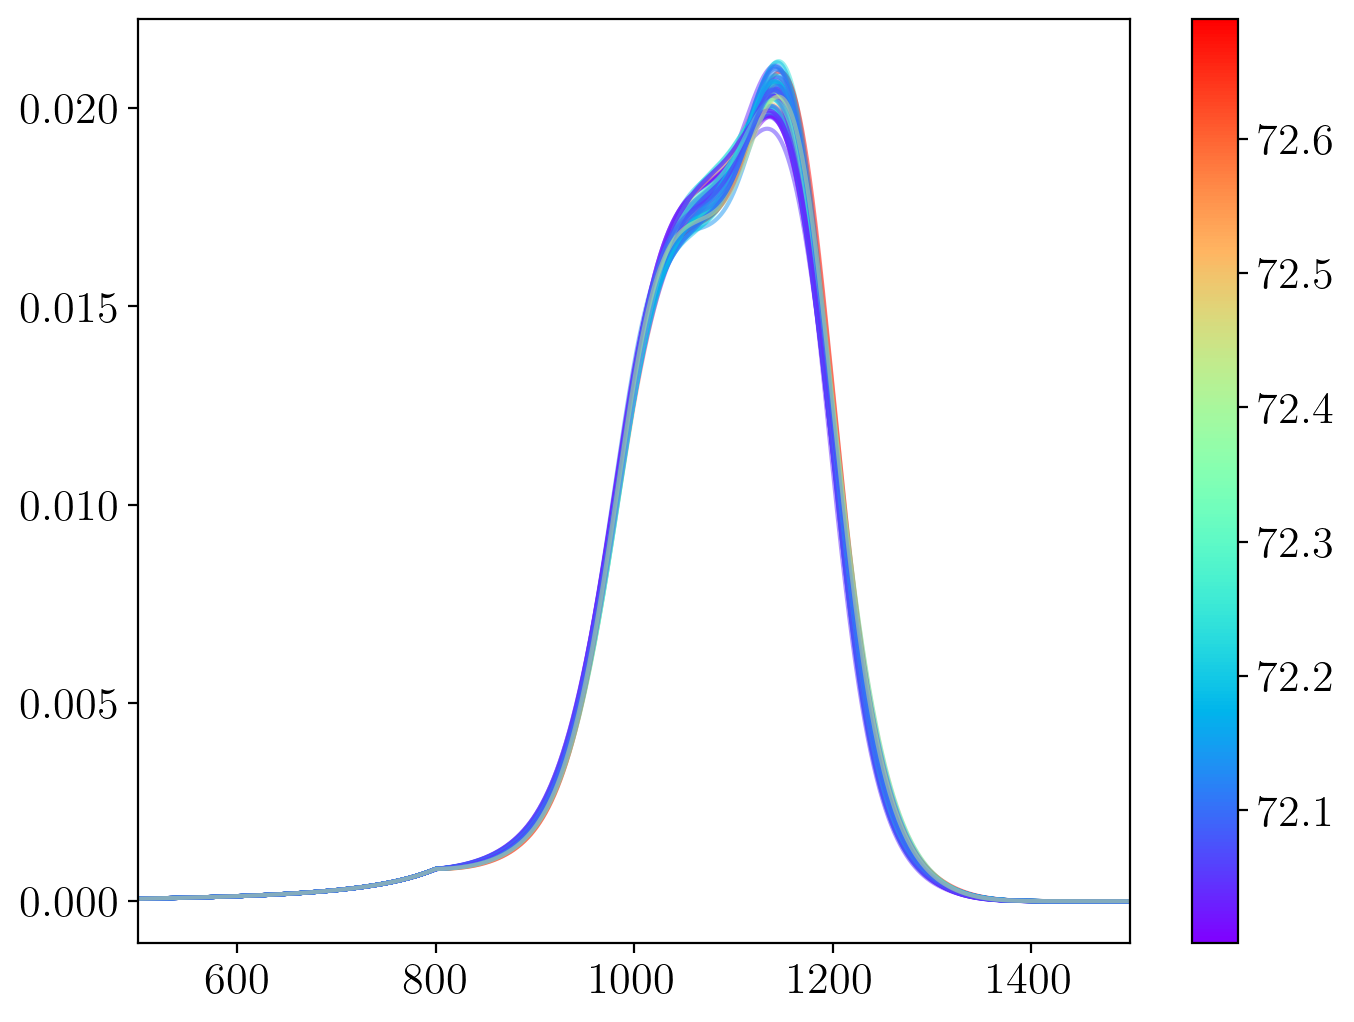

In [45]:
fig,ax = plt.subplots()
norm = mpl.colors.Normalize(vmin=modrec["H0"][high_H0_ind].min(), vmax=modrec["H0"][high_H0_ind].max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.rainbow)
cmap.set_array([])

for i in high_H0_ind:
    ax.plot(z, gz_dict[i], color = cmap.to_rgba(modrec["H0"][i]), alpha=0.5)
ax.set_xlim([500, 1500])
#ax.set_yscale("log")
#ax.set_ylim([1e-7, 1])
fig.colorbar(cmap)
plt.show()